
# Objetivo do Código

Aplicação de modelo Machine learning na manutenção preditiva previne falhas em equipamentos industriais ao analisar dados, evitando paradas não planejadas. Foram disponibilizados dados de 5 sensores presentes em uma máquina industrial. Devido a esses dados virem de sistemas reais podem ruídos e falhas dos sensores/equipamentos, para isso é necessário realizar as etapas de análise exploratória e processamento dos dados.

- Treinamento do Modelo

- Avaliação do Modelo

In [14]:
# Versão da Linguagem Python
from platform import python_version

print("Versão da Linguagem Python Usada Neste Jupyter Notebook:", python_version())

import os
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

%reload_ext watermark
%watermark -a "Eric Mochiutti" --iversions

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.12.11
Author: Eric Mochiutti

platform  : 1.0.8
numpy     : 2.1.3
keras     : 3.10.0
matplotlib: 3.10.3
tensorflow: 2.19.0
sklearn   : 1.7.0



Carregando dados normalizados dos sensores e etiquetas

In [ ]:
root_folder = os.path.abspath(os.path.join(".."))

data_processed_path = os.path.join(root_folder, "data", "processed_data")

# Labels
label_treino_defeito = np.load(
    os.path.join(data_processed_path, "label_train.npy"), allow_pickle=True
)
label_teste_defeito = np.load(
    os.path.join(data_processed_path, "label_test.npy"), allow_pickle=True
)

# Dicionário para armazenar os dados
dados_sensores = {}

# Carrega dados dos sensores
for i in range(1, 6):
    for tipo in ["treino", "teste"]:
        nome_var = f"dados_s{i}_{tipo}_N"
        nome_arquivo = f"Dados_{i}_{tipo}.npy"
        caminho = os.path.join(data_processed_path, nome_arquivo)

        dados_sensores[nome_var] = np.load(caminho, allow_pickle=True)


- Criando rótulos para a classificação (encoding para classificação)

    [1, 0, 0, 0, 0] ---> Classe A
    [0, 1, 0, 0, 0] ---> Classe B
    [0, 0, 1, 0, 0] ---> Classe C
    [0, 0, 0, 1, 0] ---> Classe D
    [0, 0, 0, 0, 1] ---> Classe E

- Dividindo os dados em dados de teste e de treino em uma proporção 80-20

Modificando o formato dos dados para serem inseridos empilhados e inseridos na rede neural 

- Os arquivos normalizados estão no formato numpy array 50000 x 200 e para o treinamento é necessário que sejam numpy array 50000 X 200 X 5

In [41]:
# 1. Redimensiona dados de treino (50000, 200, 1) para cada sensor
dados_reshape_treino = []
for i in range(1, 6):
    nome = f"dados_s{i}_treino_N"
    dados = dados_sensores[nome]
    dados_reshape_treino.append(dados.reshape((dados.shape[0], dados.shape[1], 1)))

# 2. Concatena sensores ao longo do eixo dos canais (último eixo)
X_train = np.concatenate(dados_reshape_treino, axis=-1)

print("Shape do stacked_data_treino:", X_train.shape)

# 3. One-hot encoding para os labels de treino e teste
encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(label_treino_defeito)
y_test = encoder.transform(label_teste_defeito)

# 4. (Opcional) Se quiser também empilhar os dados de teste:
dados_reshape_teste = []
for i in range(1, 6):
    nome = f"dados_s{i}_teste_N"
    dados = dados_sensores[nome]
    dados_reshape_teste.append(dados.reshape((dados.shape[0], dados.shape[1], 1)))

X_test = np.concatenate(dados_reshape_teste, axis=-1)

# 5. Número de classes
num_classes = y_train.shape[1]

# 6. Verificações
print("Shape de x_train:", X_train.shape)
print("Shape de x_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape do stacked_data_treino: (40000, 200, 5)
Shape de x_train: (40000, 200, 5)
Shape de x_test: (10000, 200, 5)
Shape de y_train: (40000, 5)
Shape de y_test: (10000, 5)


### Construindo o Modelo

- O modelo escolhido foi baseado em um trabalho que classifica séries temporais

- Rede Neural Convolucional 

In [42]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(5, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Treinamento do modelo

In [ ]:
epochs = 500
batch_size = 32

save_dir = os.path.join(root_folder, "modelo")
os.makedirs(save_dir, exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, "best_model.keras"),
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.4989 - loss: 1.2425 - val_accuracy: 0.2041 - val_loss: 15.9675 - learning_rate: 0.0010
Epoch 2/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8729 - loss: 0.4066 - val_accuracy: 0.3001 - val_loss: 4.9620 - learning_rate: 0.0010
Epoch 3/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9051 - loss: 0.2725 - val_accuracy: 0.7268 - val_loss: 2.3559 - learning_rate: 0.0010
Epoch 4/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9242 - loss: 0.2137 - val_accuracy: 0.1951 - val_loss: 13.4148 - learning_rate: 0.0010
Epoch 5/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9323 - loss: 0.1872 - val_accuracy: 0.2342 - val_loss: 9.2016 - learning_rate: 0.0010
Epoch 6/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9406 - loss: 0.1635 - val_accuracy: 0.2766 - val_loss: 8.5062 - learning_rate: 0.0010
Epoch 7/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step

- Previsões do modelo treinado (dados de teste)

In [44]:
previsoes = model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


# Avaliação do Modelo Treinado

- Funções de Custo (avaliar se o treino estava sendo efetivo)
- Matriz de Confusão (Avaliar Falsos-negativos e Falsos-Positivos)
- Class Report (Verifica a precisão, F1-score e recall para cada classe)
- ROC e UAC

Gráfico função de custo

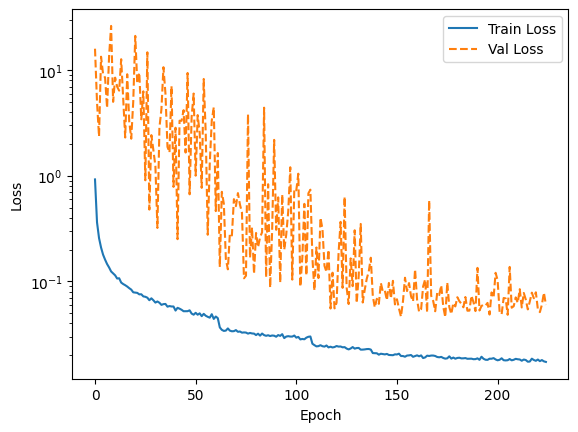

In [45]:
def plot_loss(history, label):
    plt.semilogy(history.epoch, history.history["loss"], label="Train " + label)
    plt.semilogy(
        history.epoch, history.history["val_loss"], label="Val " + label, linestyle="--"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


plot_loss(history, "Loss")
plt.legend()

Fazendo o deconding de [1, 0, 0, 0, 0] para valores de 0 a 4 para analise da matriz de confusão

In [46]:
y_test_decode = tf.argmax(y_test, axis=1)
previsoes_decode = tf.argmax(previsoes, axis=1)


Matriz de Confusão

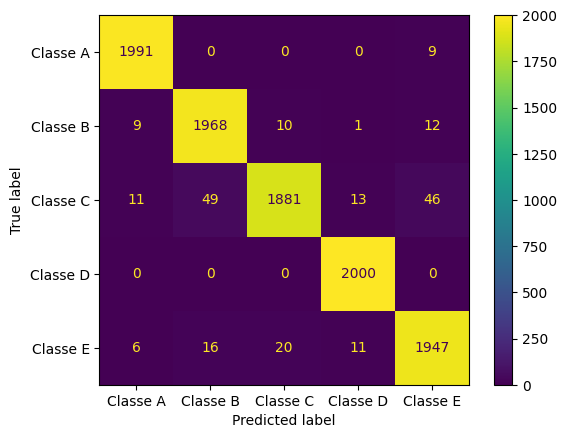

In [47]:
cm = confusion_matrix(y_test_decode, previsoes_decode)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Classe A", "Classe B", "Classe C", "Classe D", "Classe E"],
)

disp.plot()

É necessário então mais informações do problema físico relacionado a esses exemplos, vamos supor que seja um falha catastrófica que possa ocorrer com essa previsão incorreta, esse valor então não seria aceitável. Para decisão seria necessário mais informações do processo como um todo. Entretanto iremos trabalhar com a hipótese de que não é relevante esse erro (erro baixo) para dar continuidade ao estudo de caso.

Relatório de cada Classe

In [48]:
class_report = classification_report(list(y_test_decode), previsoes_decode)


| Classe | Precisão | Revocação | Pontuação F1 | Suporte |
|--------|----------|-----------|--------------|---------|
| Classe A | 0.98 | 0.99 | 0.98 | 3038 |
| Classe B | 0.96 | 0.97 | 0.96 | 3022 |
| Classe C | 0.94 | 0.96 | 0.95 | 3006 |
| Classe D | 1.00 | 1.00 | 1.00 | 2964 |
| Classe E | 0.98 | 0.94 | 0.96 | 2970 |

<br>

- Acurácia: 0.97
- Média ponderada de precisão: 0.97
- Média ponderada de revocação: 0.97
- Média ponderada da pontuação F1: 0.97
- Total de amostras: 15000

# Calcular a curva ROC


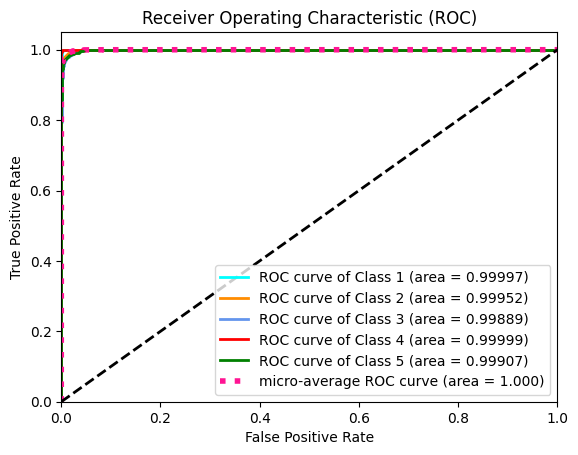

In [49]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], previsoes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular a média das curvas ROC para micro/macro-averaging
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), previsoes.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a curva ROC
plt.figure()
lw = 2
colors = cycle(
    ["aqua", "darkorange", "cornflowerblue", "red", "green"]
)  # Adicione mais cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of Class {0} (area = {1:0.5f})".format(i + 1, roc_auc[i]),
    )

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.3f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


    Análise da curva ROC
    
    - Alta Capacidade de Discriminação: Os valores AUC de 0.99 indicam que o modelo pode distinguir efetivamente entre as cinco classes.

    - Confiabilidade do Modelo: A alta AUC sugere que o modelo gera probabilidades precisas para cada classe.

    - Potencial para Aplicações Diversas: O modelo pode ser aplicado em várias áreas (do gráfico) devido à sua capacidade de classificar com precisão diferentes categorias.

    OBS: Importância da Validação Adicional: Apesar da alta AUC, é crucial validar o modelo para garantir seu desempenho confiável em situações reais.

# Análise final:

- O modelo da rede neural treinado com base nos dados apresentados mostrou-se um bom candidato a aplicação e deploy na appweb desenvolvida na etapa a seguir.